# XGBoost Model (Final Attempt)

In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from xgboost import XGBClassifier, plot_importance
import matplotlib.pyplot as plt

## EDA

In [4]:
# ---------------------- 2. Load Preprocessed Data ----------------------
# These are already cleaned and split in R
train_data = pd.read_csv("C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/train_data_final.csv")
test_data  = pd.read_csv("C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/test_data_final.csv")

# ---------------------- Convert Target to Binary (Cleaned) ----------------------
train_data['heartoa'] = train_data['heartoa'].str.strip().map({'no_OA': 0, 'OA': 1})
test_data['heartoa'] = test_data['heartoa'].str.strip().map({'no_OA': 0, 'OA': 1})
# ---------------------- Optional: Define Variable Groups (For Later Use) ----------------------
continuous_vars = ['age', 'grip_mean']
binary_vars = [
    "hepawkn", "hepawba", "hepawhi", "hepawfe", "hepawot",
    "hemobch", "hemobcs", "hemobcl", "hemobpi", "hemobpu",
    "hemobwa", "hemobre", "hemobsi", "hemobst", "headlba",
    "headlbe", "headldr", "mmpain", "sex"
]
ordinal_vars = ["hehelf", "hepaa"]

# ---------------------- Check Structure of Imported Data ----------------------
print(" Train data structure:")
print(train_data.info())

print("\n Test data structure:")
print(test_data.info())

print("\n Train Target Distribution:")
print(train_data['heartoa'].value_counts(dropna=False))

print("\n Test Target Distribution:")
print(test_data['heartoa'].value_counts(dropna=False))


 Train data structure:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3779 entries, 0 to 3778
Data columns (total 26 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   hepaa      3779 non-null   int64  
 1   hemobst    3779 non-null   int64  
 2   hepawkn    3779 non-null   int64  
 3   hepawba    3779 non-null   int64  
 4   hemobch    3779 non-null   int64  
 5   hepawhi    3779 non-null   int64  
 6   hemobcs    3779 non-null   int64  
 7   hehelf     3779 non-null   int64  
 8   grip_mean  3779 non-null   float64
 9   hepawfe    3779 non-null   int64  
 10  hemobpu    3779 non-null   int64  
 11  hemobsi    3779 non-null   int64  
 12  hemobcl    3779 non-null   int64  
 13  headldr    3779 non-null   int64  
 14  hemobwa    3779 non-null   int64  
 15  hepawot    3779 non-null   int64  
 16  hemobre    3779 non-null   int64  
 17  sex        3779 non-null   int64  
 18  mmpain     3779 non-null   int64  
 19  headlbe    3779 non-null 

## Modelling

### CV only 

In [7]:
# ---------------------- 1. Import Required Libraries ----------------------
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# ---------------------- 3. Define Features & Target ----------------------
X_train_base = train_data.drop(columns='heartoa')
y_train_base = train_data['heartoa']

X_test_base = test_data.drop(columns='heartoa')
y_test_base = test_data['heartoa']

# ---------------------- 4. Initialize XGBoost Model ----------------------
xgb_model_base = XGBClassifier(
    eval_metric="logloss",
    random_state=123,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8
)

# ---------------------- 5. Cross-Validated AUC on Training Set ----------------------
cv_base = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_proba_cv_base = cross_val_predict(xgb_model_base, X_train_base, y_train_base, cv=cv_base, method="predict_proba")[:, 1]
train_auc_base = roc_auc_score(y_train_base, y_train_proba_cv_base)

# ---------------------- 6. Fit Final Model on Full Training Set ----------------------
xgb_model_base.fit(X_train_base, y_train_base)

# ---------------------- 7. Predict on Test Set ----------------------
threshold_base = 0.45
y_test_proba_base = xgb_model_base.predict_proba(X_test_base)[:, 1]
y_test_pred_base = (y_test_proba_base >= threshold_base).astype(int)
test_auc_base = roc_auc_score(y_test_base, y_test_proba_base)

# ---------------------- 8. Evaluate Test Set ----------------------
def evaluate_test_only_base(y_true_base, y_pred_base, y_proba_base, threshold_base, dataset_name="Test"):
    acc_base = accuracy_score(y_true_base, y_pred_base)
    prec_base = precision_score(y_true_base, y_pred_base)
    rec_base = recall_score(y_true_base, y_pred_base)
    f1_base = f1_score(y_true_base, y_pred_base)
    
    cm_base = confusion_matrix(y_true_base, y_pred_base)
    TN_base, FP_base, FN_base, TP_base = cm_base.ravel()

    specificity_base = TN_base / (TN_base + FP_base) if (TN_base + FP_base) > 0 else 0
    npv_base = TN_base / (TN_base + FN_base) if (TN_base + FN_base) > 0 else 0
    f1_no_OA_base = 2 * (npv_base * specificity_base) / (npv_base + specificity_base) if (npv_base + specificity_base) > 0 else 0

    print(f"\n {dataset_name} Evaluation @ Threshold {threshold_base}")
    print(f" Accuracy        : {acc_base:.3f}")
    print(f" AUC (Train CV)  : {train_auc_base:.3f}")
    print(f" AUC (Test Set)  : {test_auc_base:.3f}\n")

    print(" Confusion Matrix:")
    print(cm_base)

    print("\n Per-Class Evaluation (Manual Calculation):")

    print("\nClass: OA (Positive Class)")
    print(f"  Precision            : {prec_base:.3f}")
    print(f"  Recall (Sensitivity) : {rec_base:.3f}")
    print(f"  F1 Score             : {f1_base:.3f}")

    print("\nClass: no_OA (Negative Class)")
    print(f"  NPV (Precision)       : {npv_base:.3f}")
    print(f"  Specificity (Recall)  : {specificity_base:.3f}")
    print(f"  F1 Score              : {f1_no_OA_base:.3f}")

# ---------------------- 9. Run Final Evaluation ----------------------
evaluate_test_only_base(y_test_base, y_test_pred_base, y_test_proba_base, threshold_base=threshold_base)


 Test Evaluation @ Threshold 0.45
 Accuracy        : 0.721
 AUC (Train CV)  : 0.737
 AUC (Test Set)  : 0.754

 Confusion Matrix:
[[507 103]
 [160 174]]

 Per-Class Evaluation (Manual Calculation):

Class: OA (Positive Class)
  Precision            : 0.628
  Recall (Sensitivity) : 0.521
  F1 Score             : 0.570

Class: no_OA (Negative Class)
  NPV (Precision)       : 0.760
  Specificity (Recall)  : 0.831
  F1 Score              : 0.794


### Class Weights

In [9]:
# ---------------------- 1. Import Required Libraries ----------------------
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------- 3. Define Features & Target ----------------------
X_train_cw = train_data.drop(columns='heartoa')
y_train_cw = train_data['heartoa']

X_test_cw = test_data.drop(columns='heartoa')
y_test_cw = test_data['heartoa']

# ---------------------- 4. Calculate Class Weight ----------------------
scale_pos_weight_cw = sum(y_train_cw == 0) / sum(y_train_cw == 1)

# ---------------------- 5. Initialize Class-Weighted XGBoost Model ----------------------
xgb_model_cw = XGBClassifier(
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight_cw,
    random_state=42,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8
)

# ---------------------- 6. Cross-Validated AUC on Training Set ----------------------
cv_cw = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_proba_cv_cw = cross_val_predict(
    xgb_model_cw, X_train_cw, y_train_cw, cv=cv_cw, method="predict_proba"
)[:, 1]
train_auc_cw = roc_auc_score(y_train_cw, y_train_proba_cv_cw)

# ---------------------- 7. Classification Threshold ----------------------
threshold_cw = 0.55
y_train_pred_cv_cw = (y_train_proba_cv_cw >= threshold_cw).astype(int)

# ---------------------- 8. Fit Model on Full Training Set ----------------------
xgb_model_cw.fit(X_train_cw, y_train_cw)

# ---------------------- 9. Predict on Test Set ----------------------
y_test_proba_cw = xgb_model_cw.predict_proba(X_test_cw)[:, 1]
y_test_pred_cw = (y_test_proba_cw >= threshold_cw).astype(int)
test_auc_cw = roc_auc_score(y_test_cw, y_test_proba_cw)

# ---------------------- 10. Evaluate Test Set Only ----------------------
def evaluate_test_only(y_true, y_pred, y_proba, auc_train, auc_test, threshold, dataset_name="Test"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    f1_no_OA = 2 * (npv * specificity) / (npv + specificity) if (npv + specificity) > 0 else 0

    print(f"\n {dataset_name} Evaluation @ Threshold {threshold}")
    print(f" Accuracy        : {acc:.3f}")
    print(f" AUC (Train CV)  : {auc_train:.3f}")
    print(f" AUC (Test Set)  : {auc_test:.3f}")

    print("\n Confusion Matrix:")
    print(cm)

    print("\n Per-Class Evaluation:")

    print("\nClass: OA (Positive Class)")
    print(f"  Precision            : {prec:.3f}")
    print(f"  Recall (Sensitivity) : {rec:.3f}")
    print(f"  F1 Score             : {f1:.3f}")

    print("\nClass: no_OA (Negative Class)")
    print(f"  NPV (Precision)       : {npv:.3f}")
    print(f"  Specificity (Recall)  : {specificity:.3f}")
    print(f"  F1 Score              : {f1_no_OA:.3f}")

# ---------------------- 11. Final Test Evaluation ----------------------
evaluate_test_only(
    y_test_cw, y_test_pred_cw, y_test_proba_cw,
    auc_train=train_auc_cw,
    auc_test=test_auc_cw,
    threshold=threshold_cw,
    dataset_name="Test"
)


 Test Evaluation @ Threshold 0.55
 Accuracy        : 0.709
 AUC (Train CV)  : 0.735
 AUC (Test Set)  : 0.754

 Confusion Matrix:
[[481 129]
 [146 188]]

 Per-Class Evaluation:

Class: OA (Positive Class)
  Precision            : 0.593
  Recall (Sensitivity) : 0.563
  F1 Score             : 0.578

Class: no_OA (Negative Class)
  NPV (Precision)       : 0.767
  Specificity (Recall)  : 0.789
  F1 Score              : 0.778


### Upsampling

In [11]:
# ---------------------- 1. Import Required Libraries ----------------------
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from imblearn.over_sampling import RandomOverSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------- 3. Define Features & Target ----------------------
X_train_up = train_data.drop(columns='heartoa')
y_train_up = train_data['heartoa']

X_test_up = test_data.drop(columns='heartoa')
y_test_up = test_data['heartoa']

# ---------------------- 4. Apply Upsampling on Training Set ----------------------
ros = RandomOverSampler(random_state=42)
X_train_up_resampled, y_train_up_resampled = ros.fit_resample(X_train_up, y_train_up)

# ---------------------- 5. Initialize XGBoost Model ----------------------
xgb_model_up = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8
)

# ---------------------- 6. Cross-Validated Train Probabilities and AUC ----------------------
cv_up = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_proba_cv_up = cross_val_predict(
    xgb_model_up, X_train_up_resampled, y_train_up_resampled, cv=cv_up, method="predict_proba"
)[:, 1]
train_auc_up = roc_auc_score(y_train_up_resampled, y_train_proba_cv_up)

# ---------------------- 7. Classification Threshold ----------------------
threshold_up = 0.5
y_train_pred_cv_up = (y_train_proba_cv_up >= threshold_up).astype(int)

# ---------------------- 8. Fit Model on Full Resampled Training Set ----------------------
xgb_model_up.fit(X_train_up_resampled, y_train_up_resampled)

# ---------------------- 9. Predict on Untouched Test Set ----------------------
y_test_proba_up = xgb_model_up.predict_proba(X_test_up)[:, 1]
y_test_pred_up = (y_test_proba_up >= threshold_up).astype(int)
test_auc_up = roc_auc_score(y_test_up, y_test_proba_up)

# ---------------------- 10. Evaluate Test Set Only ----------------------
def evaluate_test_only(y_true, y_pred, y_proba, auc_train, auc_test, threshold, dataset_name="Test"):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    f1_no_OA = 2 * (npv * specificity) / (npv + specificity) if (npv + specificity) > 0 else 0

    print(f"\n {dataset_name} Evaluation @ Threshold {threshold}")
    print(f" Accuracy        : {acc:.3f}")
    print(f" AUC (Train CV)  : {auc_train:.3f}")
    print(f" AUC (Test Set)  : {auc_test:.3f}")

    print("\n Confusion Matrix:")
    print(cm)

    print("\n Per-Class Evaluation:")

    print("\nClass: OA (Positive Class)")
    print(f"  Precision            : {prec:.3f}")
    print(f"  Recall (Sensitivity) : {rec:.3f}")
    print(f"  F1 Score             : {f1:.3f}")

    print("\nClass: no_OA (Negative Class)")
    print(f"  NPV (Precision)       : {npv:.3f}")
    print(f"  Specificity (Recall)  : {specificity:.3f}")
    print(f"  F1 Score              : {f1_no_OA:.3f}")

# ---------------------- 11. Final Test Evaluation ----------------------
evaluate_test_only(
    y_test_up, y_test_pred_up, y_test_proba_up,
    auc_train=train_auc_up,
    auc_test=test_auc_up,
    threshold=threshold_up,
    dataset_name="Test"
)


 Test Evaluation @ Threshold 0.5
 Accuracy        : 0.714
 AUC (Train CV)  : 0.762
 AUC (Test Set)  : 0.752

 Confusion Matrix:
[[466 144]
 [126 208]]

 Per-Class Evaluation:

Class: OA (Positive Class)
  Precision            : 0.591
  Recall (Sensitivity) : 0.623
  F1 Score             : 0.606

Class: no_OA (Negative Class)
  NPV (Precision)       : 0.787
  Specificity (Recall)  : 0.764
  F1 Score              : 0.775


### Downsampling

In [13]:
# ---------------------- 1. Import Required Libraries ----------------------
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix
)
from imblearn.under_sampling import RandomUnderSampler
from statsmodels.stats.proportion import proportion_confint
import numpy as np
import pandas as pd

# ---------------------- 2. Define Features & Target ----------------------
X_train_down = train_data.drop(columns='heartoa')
y_train_down = train_data['heartoa']

X_test_down = test_data.drop(columns='heartoa')
y_test_down = test_data['heartoa']

# ---------------------- 3. Downsample the Training Set ----------------------
rus = RandomUnderSampler(random_state=42)
X_train_down_resampled, y_train_down_resampled = rus.fit_resample(X_train_down, y_train_down)

# ---------------------- 4. Initialize XGBoost Model ----------------------
xgb_model_down = XGBClassifier(
    eval_metric='logloss',
    random_state=42,
    max_depth=2,
    subsample=0.8,
    colsample_bytree=0.8
)

# ---------------------- 5. Cross-Validated AUC on Downsampled Training Set ----------------------
cv_down = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_proba_cv_down = cross_val_predict(
    xgb_model_down, X_train_down_resampled, y_train_down_resampled,
    cv=cv_down, method="predict_proba"
)[:, 1]
train_auc_down = roc_auc_score(y_train_down_resampled, y_train_proba_cv_down)

# ---------------------- 6. Train Final Model on Downsampled Data ----------------------
xgb_model_down.fit(X_train_down_resampled, y_train_down_resampled)

# ---------------------- 7. Predict on Untouched Test Set ----------------------
threshold_down = 0.5
y_test_proba_down = xgb_model_down.predict_proba(X_test_down)[:, 1]
y_test_pred_down = (y_test_proba_down >= threshold_down).astype(int)
test_auc_down = roc_auc_score(y_test_down, y_test_proba_down)

# ---------------------- 8. Define Evaluation Function with 95% CIs ----------------------
from sklearn.utils import resample

def bootstrap_auc_ci(y_true, y_score, n_bootstraps=1000, ci=0.95):
    rng = np.random.RandomState(42)
    bootstrapped_scores = []
    y_true = np.array(y_true)
    y_score = np.array(y_score)

    for _ in range(n_bootstraps):
        indices = rng.randint(0, len(y_score), len(y_score))
        if len(np.unique(y_true[indices])) < 2:
            continue
        score = roc_auc_score(y_true[indices], y_score[indices])
        bootstrapped_scores.append(score)

    sorted_scores = np.sort(bootstrapped_scores)
    lower = sorted_scores[int((1.0 - ci) / 2 * len(sorted_scores))]
    upper = sorted_scores[int((1.0 + ci) / 2 * len(sorted_scores))]
    return round(lower, 3), round(upper, 3)

def evaluate_test_only_with_ci(y_true, y_pred, y_proba, auc_train, auc_test, threshold, dataset_name="Test", alpha=0.05):
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()

    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    npv = TN / (TN + FN) if (TN + FN) > 0 else 0
    f1_no_OA = 2 * (npv * specificity) / (npv + specificity) if (npv + specificity) > 0 else 0

    # Wilson CIs
    def ci_wilson(success, total):
        lower, upper = proportion_confint(count=success, nobs=total, alpha=alpha, method='wilson')
        return round(lower, 3), round(upper, 3)

    ci_acc  = ci_wilson(TP + TN, len(y_true))
    ci_rec  = ci_wilson(TP, TP + FN)
    ci_spec = ci_wilson(TN, TN + FP)
    ci_prec = ci_wilson(TP, TP + FP)
    ci_npv  = ci_wilson(TN, TN + FN)
    ci_auc_test = bootstrap_auc_ci(y_true, y_proba)

    # Output
    print(f"\n {dataset_name} Evaluation @ Threshold {threshold}")
    print(f" Accuracy        : {acc:.3f} (95% CI: {ci_acc[0]}–{ci_acc[1]})")
    print(f" AUC (Train CV)  : {auc_train:.3f}")
    print(f" AUC (Test Set)  : {auc_test:.3f} (95% CI: {ci_auc_test[0]}–{ci_auc_test[1]})")

    print("\n Confusion Matrix:")
    print(cm)

    print("\n Per-Class Evaluation:")

    print("\nClass: OA (Positive Class)")
    print(f"  Precision            : {prec:.3f} (95% CI: {ci_prec[0]}–{ci_prec[1]})")
    print(f"  Recall (Sensitivity) : {rec:.3f} (95% CI: {ci_rec[0]}–{ci_rec[1]})")
    print(f"  F1 Score             : {f1:.3f}")

    print("\nClass: no_OA (Negative Class)")
    print(f"  NPV (Precision)       : {npv:.3f} (95% CI: {ci_npv[0]}–{ci_npv[1]})")
    print(f"  Specificity (Recall)  : {specificity:.3f} (95% CI: {ci_spec[0]}–{ci_spec[1]})")
    print(f"  F1 Score              : {f1_no_OA:.3f}")

# ---------------------- 9. Final Test Evaluation with CI ----------------------
evaluate_test_only_with_ci(
    y_test_down, y_test_pred_down, y_test_proba_down,
    auc_train=train_auc_down,
    auc_test=test_auc_down,
    threshold=threshold_down,
    dataset_name="Test"
)


 Test Evaluation @ Threshold 0.5
 Accuracy        : 0.713 (95% CI: 0.683–0.741)
 AUC (Train CV)  : 0.728
 AUC (Test Set)  : 0.761 (95% CI: 0.727–0.791)

 Confusion Matrix:
[[461 149]
 [122 212]]

 Per-Class Evaluation:

Class: OA (Positive Class)
  Precision            : 0.587 (95% CI: 0.536–0.637)
  Recall (Sensitivity) : 0.635 (95% CI: 0.582–0.685)
  F1 Score             : 0.610

Class: no_OA (Negative Class)
  NPV (Precision)       : 0.791 (95% CI: 0.756–0.822)
  Specificity (Recall)  : 0.756 (95% CI: 0.72–0.788)
  F1 Score              : 0.773


### Gridsearch

In [15]:
# ---------------------- 1. Import Required Libraries ----------------------
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, confusion_matrix, make_scorer
)
from imblearn.under_sampling import RandomUnderSampler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ---------------------- 2. Load Preprocessed Data (Already Split) ----------------------
#train_data = pd.read_csv("C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/train_data_final.csv")
#test_data  = pd.read_csv("C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/test_data_final.csv")

# ---------------------- 3. Convert Target to Binary ----------------------
#train_data['heartoa'] = train_data['heartoa'].str.strip().map({'no_OA': 0, 'OA': 1})
#test_data['heartoa'] = test_data['heartoa'].str.strip().map({'no_OA': 0, 'OA': 1})

# ---------------------- 4. Define Features & Target ----------------------
X_train_tuned = train_data.drop(columns='heartoa')
y_train_tuned = train_data['heartoa']

X_test_tuned = test_data.drop(columns='heartoa')
y_test_tuned = test_data['heartoa']

# ---------------------- 5. Downsample the Training Set ----------------------
rus_tuned = RandomUnderSampler(random_state=42)
X_train_resampled, y_train_resampled = rus_tuned.fit_resample(X_train_tuned, y_train_tuned)

# ---------------------- 6. Define Model and Grid ----------------------
xgb_model_tuned = XGBClassifier(eval_metric='logloss', random_state=42)

param_grid_tuned = {
    'n_estimators': [100, 200],
    'max_depth': [2, 4, 6],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0]
}

precision_scorer_tuned = make_scorer(precision_score, pos_label=1)

grid_search_tuned = GridSearchCV(
    estimator=xgb_model_tuned,
    param_grid=param_grid_tuned,
    scoring=precision_scorer_tuned,
    cv=StratifiedKFold(n_splits=10, shuffle=True, random_state=42),
    verbose=2,
    n_jobs=-1
)

# ---------------------- 7. Fit Grid Search ----------------------
grid_search_tuned.fit(X_train_resampled, y_train_resampled)
best_model_tuned = grid_search_tuned.best_estimator_
print("\n Best Hyperparameters:", grid_search_tuned.best_params_)

# ---------------------- 8. Cross-Validated Probabilities & AUC (Train) ----------------------
cv_tuned = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
y_train_proba_cv_tuned = cross_val_predict(
    best_model_tuned, X_train_resampled, y_train_resampled, cv=cv_tuned, method="predict_proba"
)[:, 1]
train_auc_tuned = roc_auc_score(y_train_resampled, y_train_proba_cv_tuned)

# ---------------------- 9. Predict on Test Set ----------------------
threshold_tuned = 0.55
y_test_proba_tuned = best_model_tuned.predict_proba(X_test_tuned)[:, 1]
y_test_pred_tuned = (y_test_proba_tuned >= threshold_tuned).astype(int)
test_auc_tuned = roc_auc_score(y_test_tuned, y_test_proba_tuned)

# ---------------------- 10. Evaluation Function ----------------------
def evaluate_test_only_tuned(y_true_tuned, y_pred_tuned, y_proba_tuned, auc_train_tuned, auc_test_tuned, threshold_tuned, dataset_name="Test"):
    acc_tuned = accuracy_score(y_true_tuned, y_pred_tuned)
    prec_tuned = precision_score(y_true_tuned, y_pred_tuned)
    rec_tuned = recall_score(y_true_tuned, y_pred_tuned)
    f1_tuned = f1_score(y_true_tuned, y_pred_tuned)

    cm_tuned = confusion_matrix(y_true_tuned, y_pred_tuned)
    TN_tuned, FP_tuned, FN_tuned, TP_tuned = cm_tuned.ravel()

    specificity_tuned = TN_tuned / (TN_tuned + FP_tuned) if (TN_tuned + FP_tuned) > 0 else 0
    npv_tuned = TN_tuned / (TN_tuned + FN_tuned) if (TN_tuned + FN_tuned) > 0 else 0
    f1_no_OA_tuned = 2 * (npv_tuned * specificity_tuned) / (npv_tuned + specificity_tuned) if (npv_tuned + specificity_tuned) > 0 else 0

    print(f"\n {dataset_name} Evaluation @ Threshold {threshold_tuned}")
    print(f" Accuracy        : {acc_tuned:.3f}")
    print(f" AUC (Train CV)  : {auc_train_tuned:.3f}")
    print(f" AUC (Test Set)  : {auc_test_tuned:.3f}")

    print("\n Confusion Matrix:")
    print(cm_tuned)

    print("\n Per-Class Evaluation:")

    print("\nClass: OA (Positive Class)")
    print(f"  Precision            : {prec_tuned:.3f}")
    print(f"  Recall (Sensitivity) : {rec_tuned:.3f}")
    print(f"  F1 Score             : {f1_tuned:.3f}")

    print("\nClass: no_OA (Negative Class)")
    print(f"  NPV (Precision)       : {npv_tuned:.3f}")
    print(f"  Specificity (Recall)  : {specificity_tuned:.3f}")
    print(f"  F1 Score              : {f1_no_OA_tuned:.3f}")

# ---------------------- 11. Final Test Evaluation ----------------------
evaluate_test_only_tuned(
    y_test_tuned, y_test_pred_tuned, y_test_proba_tuned,
    auc_train_tuned=train_auc_tuned,
    auc_test_tuned=test_auc_tuned,
    threshold_tuned=threshold_tuned,
    dataset_name="Test"
)


Fitting 10 folds for each of 72 candidates, totalling 720 fits

 Best Hyperparameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 100, 'subsample': 0.8}

 Test Evaluation @ Threshold 0.55
 Accuracy        : 0.725
 AUC (Train CV)  : 0.741
 AUC (Test Set)  : 0.762

 Confusion Matrix:
[[494 116]
 [144 190]]

 Per-Class Evaluation:

Class: OA (Positive Class)
  Precision            : 0.621
  Recall (Sensitivity) : 0.569
  F1 Score             : 0.594

Class: no_OA (Negative Class)
  NPV (Precision)       : 0.774
  Specificity (Recall)  : 0.810
  F1 Score              : 0.792


### Plotting AUC

### ROC-Curve Plot

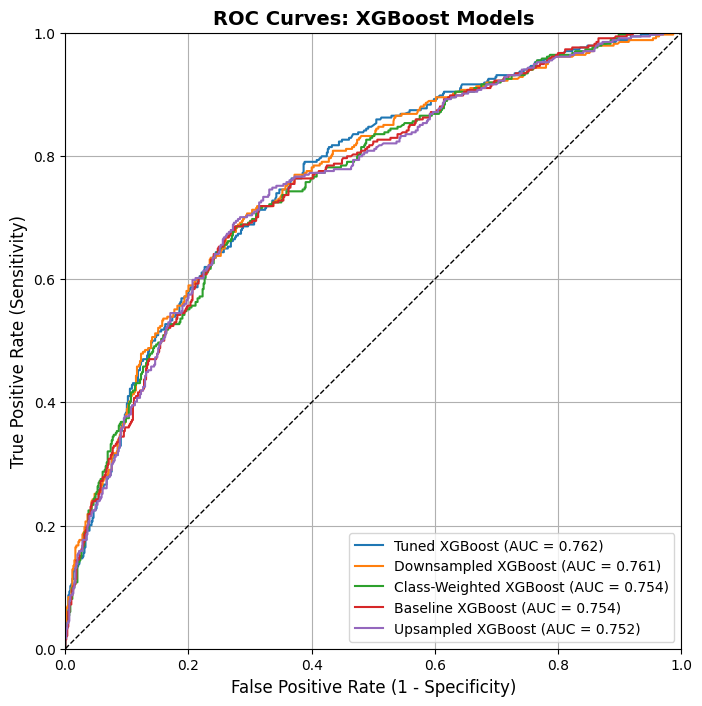

In [18]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# --- Compute ROC Curves ---
roc_data = []

# Baseline
fpr_base, tpr_base, _ = roc_curve(y_test_base, y_test_proba_base)
roc_data.append({
    'label': "Baseline XGBoost",
    'fpr': fpr_base,
    'tpr': tpr_base,
    'auc': auc(fpr_base, tpr_base)
})

# Class-Weighted
fpr_cw, tpr_cw, _ = roc_curve(y_test_cw, y_test_proba_cw)
roc_data.append({
    'label': "Class-Weighted XGBoost",
    'fpr': fpr_cw,
    'tpr': tpr_cw,
    'auc': auc(fpr_cw, tpr_cw)
})

# Upsampled
fpr_up, tpr_up, _ = roc_curve(y_test_up, y_test_proba_up)
roc_data.append({
    'label': "Upsampled XGBoost",
    'fpr': fpr_up,
    'tpr': tpr_up,
    'auc': auc(fpr_up, tpr_up)
})

# Downsampled
fpr_down, tpr_down, _ = roc_curve(y_test_down, y_test_proba_down)
roc_data.append({
    'label': "Downsampled XGBoost",
    'fpr': fpr_down,
    'tpr': tpr_down,
    'auc': auc(fpr_down, tpr_down)
})

# Tuned
fpr_tuned, tpr_tuned, _ = roc_curve(y_test_tuned, y_test_proba_tuned)
roc_data.append({
    'label': "Tuned XGBoost",
    'fpr': fpr_tuned,
    'tpr': tpr_tuned,
    'auc': auc(fpr_tuned, tpr_tuned)
})

# --- Sort by AUC Descending ---
roc_data_sorted = sorted(roc_data, key=lambda x: x['auc'], reverse=True)

# --- Plot ROC Curves ---
plt.figure(figsize=(8, 8))

for model in roc_data_sorted:
    plt.plot(model['fpr'], model['tpr'],
             label=f"{model['label']} (AUC = {model['auc']:.3f})")

plt.plot([0, 1], [0, 1], "k--", lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel("False Positive Rate (1 - Specificity)", fontsize=12)
plt.ylabel("True Positive Rate (Sensitivity)", fontsize=12)
plt.title("ROC Curves: XGBoost Models", fontsize=14, fontweight="bold")
plt.legend(loc="lower right", fontsize=10)
plt.grid(True)
plt.gca().set_aspect('equal', adjustable='box')

# --- Save Plot ---
plt.savefig(
    "C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/xgboost_roc_curves_sorted.png",
    dpi=300, bbox_inches='tight', facecolor='white'
)
plt.show()



In [19]:
from sklearn.metrics import roc_curve, auc
import pandas as pd

# --- Compute ROC for XGBoost Downsampled ---
fpr_xgb_down, tpr_xgb_down, _ = roc_curve(y_test_down, y_test_proba_down)
auc_xgb_down = auc(fpr_xgb_down, tpr_xgb_down)

# --- Create DataFrame ---
roc_xgb_down_df = pd.DataFrame({
    "FPR": fpr_xgb_down,
    "TPR": tpr_xgb_down,
    "Model": [f"XGBoost (Downsampled) - AUC: {auc_xgb_down:.3f}"] * len(fpr_xgb_down)
})

# --- Export to CSV ---
roc_xgb_down_df.to_csv(
    "C:/Users/tasne/OneDrive/Desktop/UoB/M7_Interdisciplinary Health Data Research Project/Final Binary/roc_xgb_downsampled.csv",
    index=False
)